C:\Users\shaje\AppData\Local\Temp\ipykernel_13216\2677075747.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data_filtered.set_index('date_added').resample('M').mean().dropna()
c:\Users\shaje\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\shaje\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\shaje\AppData\Local\Temp\ipykernel_13216\2677075747.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=monthly_data.index[-1],

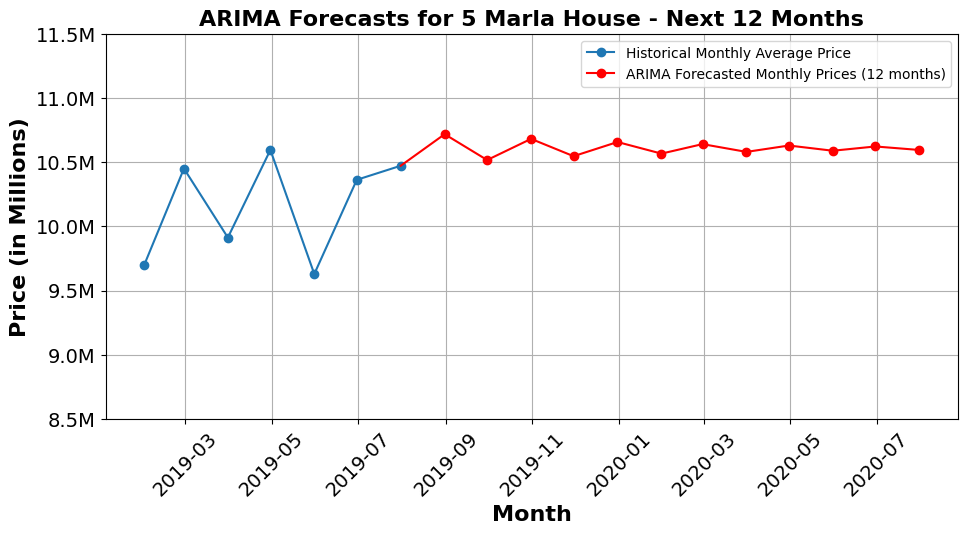

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the data
data_path = '2019.csv'
data = pd.read_csv(data_path)
data['date_added'] = pd.to_datetime(data['date_added'])
data_filtered = data[['date_added', 'Area Size', 'price']]
data_filtered = data_filtered[data_filtered['Area Size'] == 5]  # Focusing on 5 marla plots

# Resample the data on a monthly basis and calculate the mean
monthly_data = data_filtered.set_index('date_added').resample('M').mean().dropna()

# Define additional ARIMA orders
arima_orders = [(1, 1, 1)]
colors = ['red', 'green', 'blue', 'purple', 'cyan']  # Colors for each model

# Plot historical data
plt.figure(figsize=(11, 5))
plt.plot(
    monthly_data.index, 
    monthly_data['price'], 
    label='Historical Monthly Average Price', 
    marker='o', 
    linestyle='-'
)

# Fit each ARIMA model, forecast, and plot the results
for order, color in zip(arima_orders, colors):
    model = ARIMA(monthly_data['price'], order=order)
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=12)
    forecast_mean = forecast.predicted_mean
    forecast_dates = pd.date_range(start=monthly_data.index[-1], periods=13, freq='M')[1:]
    plt.plot(
        forecast_dates,
        forecast_mean,
        color=color,
        marker='o',
        linestyle='-',
        label=f'ARIMA Forecasted Monthly Prices (12 months)'
    )

    # Connect the last actual point to the first forecast point
    plt.plot([monthly_data.index[-1], forecast_dates[0]],
             [monthly_data['price'].iloc[-1], forecast_mean.iloc[0]],
             color=color, linestyle='-')

# Adjust y-axis limits for a better visual appearance
price_min = monthly_data['price'].min()
price_max = monthly_data['price'].max()
plt.ylim([price_min * 0.93, price_max * 1.07])  # Fine-tuned adjustment

plt.title('ARIMA Forecasts for 5 Marla House - Next 12 Months', fontsize=16, weight='bold')
plt.xlabel('Month', fontsize=16, weight='bold')
plt.ylabel('Price (in Millions)', fontsize=16, weight='bold')

# Customize the x-axis and y-axis tick labels
plt.xticks(rotation = 45, fontsize=14 )

# Extract current y-tick positions
yticks = plt.gca().get_yticks()
# Set y-tick positions and labels
plt.yticks(yticks, labels=[f'{label / 1e6:.1f}M' for label in yticks], fontsize=14,)

# Set background color to white
plt.gcf().set_facecolor('white')
plt.gca().set_facecolor('white')

plt.legend()
plt.grid(True)
plt.show()


In [3]:
# Check for stationarity using the Augmented Dickey-Fuller test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value {}: {}'.format(key, value))
    return result[1]

# Initial stationarity check
p_value = check_stationarity(monthly_data['price'])
d = 0

ADF Statistic: -2.001827409474599
p-value: 0.285772419077454
Critical Value 1%: -6.045114
Critical Value 5%: -3.9292800000000003
Critical Value 10%: -2.98681


ADF Statistic: -2.001827409474599
p-value: 0.285772419077454
Critical Value 1%: -6.045114
Critical Value 5%: -3.9292800000000003
Critical Value 10%: -2.98681
ADF Statistic: -6.147653065571846
p-value: 7.697447027440969e-08
Critical Value 1%: -6.045114
Critical Value 5%: -3.9292800000000003
Critical Value 10%: -2.98681
The series is stationary with d=1


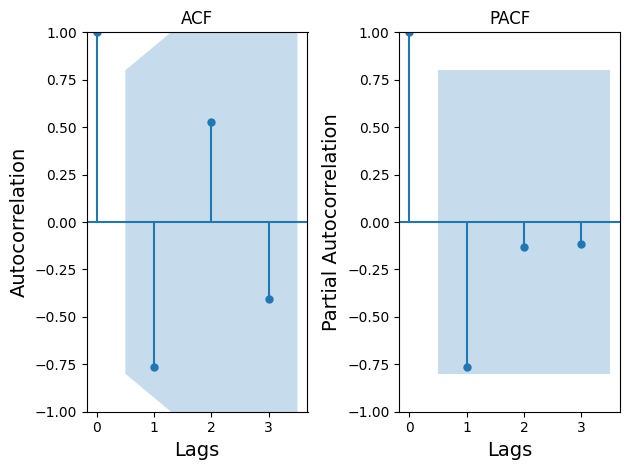

In [12]:
# Check for stationarity using the Augmented Dickey-Fuller test
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value {}: {}'.format(key, value))
    return result[1]

# Initial stationarity check
p_value = check_stationarity(monthly_data['price'])
d = 0

# Apply differencing if the series is not stationary
while p_value > 0.05 and d < 2:  # Limit to d < 2 for practical purposes
    d += 1
    monthly_data['price_diff'] = monthly_data['price'].diff(d).dropna()
    p_value = check_stationarity(monthly_data['price_diff'].dropna())

print(f'The series is stationary with d={d}')

# Ensure there are enough data points after differencing
if d > 0:
    diff_data = monthly_data['price_diff'].dropna()
else:
    diff_data = monthly_data['price']

# Ensure there are enough lags for ACF/PACF plots
max_lags = min(20, len(diff_data) // 2)

# Plot ACF
plt.subplot(121)
plot_acf(diff_data, lags=max_lags, ax=plt.gca())
plt.title('ACF')
plt.xlabel('Lags', fontsize=14)  # Adjust fontsize as needed
plt.ylabel('Autocorrelation', fontsize=14)  # Adjust fontsize as needed

# Plot PACF
plt.subplot(122)
plot_pacf(diff_data, lags=max_lags, ax=plt.gca())
plt.title('PACF')
plt.xlabel('Lags', fontsize=14)  # Adjust fontsize as needed
plt.ylabel('Partial Autocorrelation', fontsize=14)  # Adjust fontsize as needed

plt.tight_layout()  # Ensures plots are properly spaced
plt.show()
# Based on ACF and PACF plots, we can suggest p and q values
# For demonstration purposes, we will use (p=1, d=d, q=1)
p = 1
q = 1